In [1]:
# !pip install -r requirements.txt
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=df465aafa0bf8d9d002f5491eb1915689590c17ca8ce9b3ea8767aad1f8fbc67
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# 0. 라이브러리

# 1. Load Data
- 5core userID num :  281887
- 5core movieID num :  59252
- 5core rating num :  3236784
- ----------
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- ----------
- 10core userID num :  79542
- 10core movieID num :  30084
- 10core rating num :  1785734
- ----------
- 15core userID num :  33821
- 15core movieID num :  17410
- 15core rating num :  1115902
- ----------
- 20core userID num :  16221
- 20core movieID num :  9919
- 20core rating num :  701036

In [2]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle
import random

In [ ]:
# from tensorflow.python.client import device_lib
# tf.config.list_physical_devices('GPU')

In [3]:
# 혹시모르니 아래 코드 세개 다 쓰기
seed_num = 42
tf.random.set_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data load
# data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
overall = train_set.shape[0] + valid_set.shape[0] + test_set.shape[0]
print('train:validation:test = %.4f:%.4f:%.4f'%((train_set.shape[0] / overall), (valid_set.shape[0] / overall), (test_set.shape[0] / overall)))

train:validation:test = 0.7000:0.1000:0.2000


In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1268783,196894,17092,1.00,0.9118,0.795,0.205,0.000,0.00,16.67,0.00,0.00,33.33,0.00,0.00,0.00,0.00,33.33
2085294,144722,36136,1.00,0.8020,0.423,0.495,0.082,8.33,0.00,8.33,0.00,0.00,16.67,0.00,8.33,16.67,8.33
1601782,187298,26274,1.00,0.9657,0.263,0.697,0.039,1.11,10.00,0.00,6.67,2.22,0.00,2.22,6.67,1.11,10.00
286943,140132,31748,1.00,0.9667,0.621,0.379,0.000,0.00,0.00,0.00,0.00,17.65,0.00,0.00,5.88,0.00,17.65
1072946,101551,10355,0.75,0.8957,0.496,0.504,0.000,6.25,31.25,0.00,6.25,31.25,12.50,25.00,31.25,0.00,31.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612962,42980,58606,1.00,0.9958,0.512,0.488,0.000,0.00,8.86,0.00,0.00,12.66,0.00,5.06,7.59,0.00,20.25
1855528,23396,32231,1.00,0.9628,0.206,0.704,0.090,2.42,6.45,2.42,4.03,5.65,1.61,1.61,7.26,8.06,11.29
2025236,134838,35643,1.00,0.9903,0.521,0.443,0.036,1.85,7.41,1.85,3.70,7.41,0.00,1.85,5.56,1.85,11.11
1028586,46156,9128,1.00,0.8166,0.517,0.483,0.000,0.00,22.22,0.00,11.11,22.22,0.00,0.00,22.22,0.00,22.22


# 3.Model

In [5]:
def conv_block(n_layers, latent_dims, names):
    ModuleList, DropoutList = [], []
    for i, _ in enumerate(range(n_layers)):
        ModuleList.append(Dense(latent_dims, activation='relu', name=f'{names}{i+1}'))
        latent_dims //= 2
    return ModuleList

In [6]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    anger_input = Input(shape=(1,), dtype='int32', name='AngerInput')
    anger_dense = Dense(units=1, activation='relu', name='Dense_Anger')(anger_input)

    anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    anticipation_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anticipation_input)

    disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    disgust_dense = Dense(units=1, activation='relu', name='Dense_Disgust')(disgust_input)

    fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    fear_dense = Dense(units=1, activation='relu', name='Dense_Fear')(fear_input)

    joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    joy_dense = Dense(units=1, activation='relu', name='Dense_Joy')(joy_input)

    sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    sadness_dense = Dense(units=1, activation='relu', name='Dense_Sadness')(sadness_input)

    surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    surprise_dense = Dense(units=1, activation='relu', name='Dense_Surprise')(surprise_input)

    trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')
    trust_dense = Dense(units=1, activation='relu', name='Dense_Trust')(trust_input)

    # Sentiment = Concatenate(name='SentimentLayer')([anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])
    # Sentiment concatenation
    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, anger_input, anticipation_input, disgust_input, fear_input, joy_input, sadness_input, surprise_input, trust_input], outputs=outputs)
    return model

In [ ]:
user_num = 281335
item_num = 59044

id_dims = 128# each 32 dims
total_layer_dims = 32 # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16

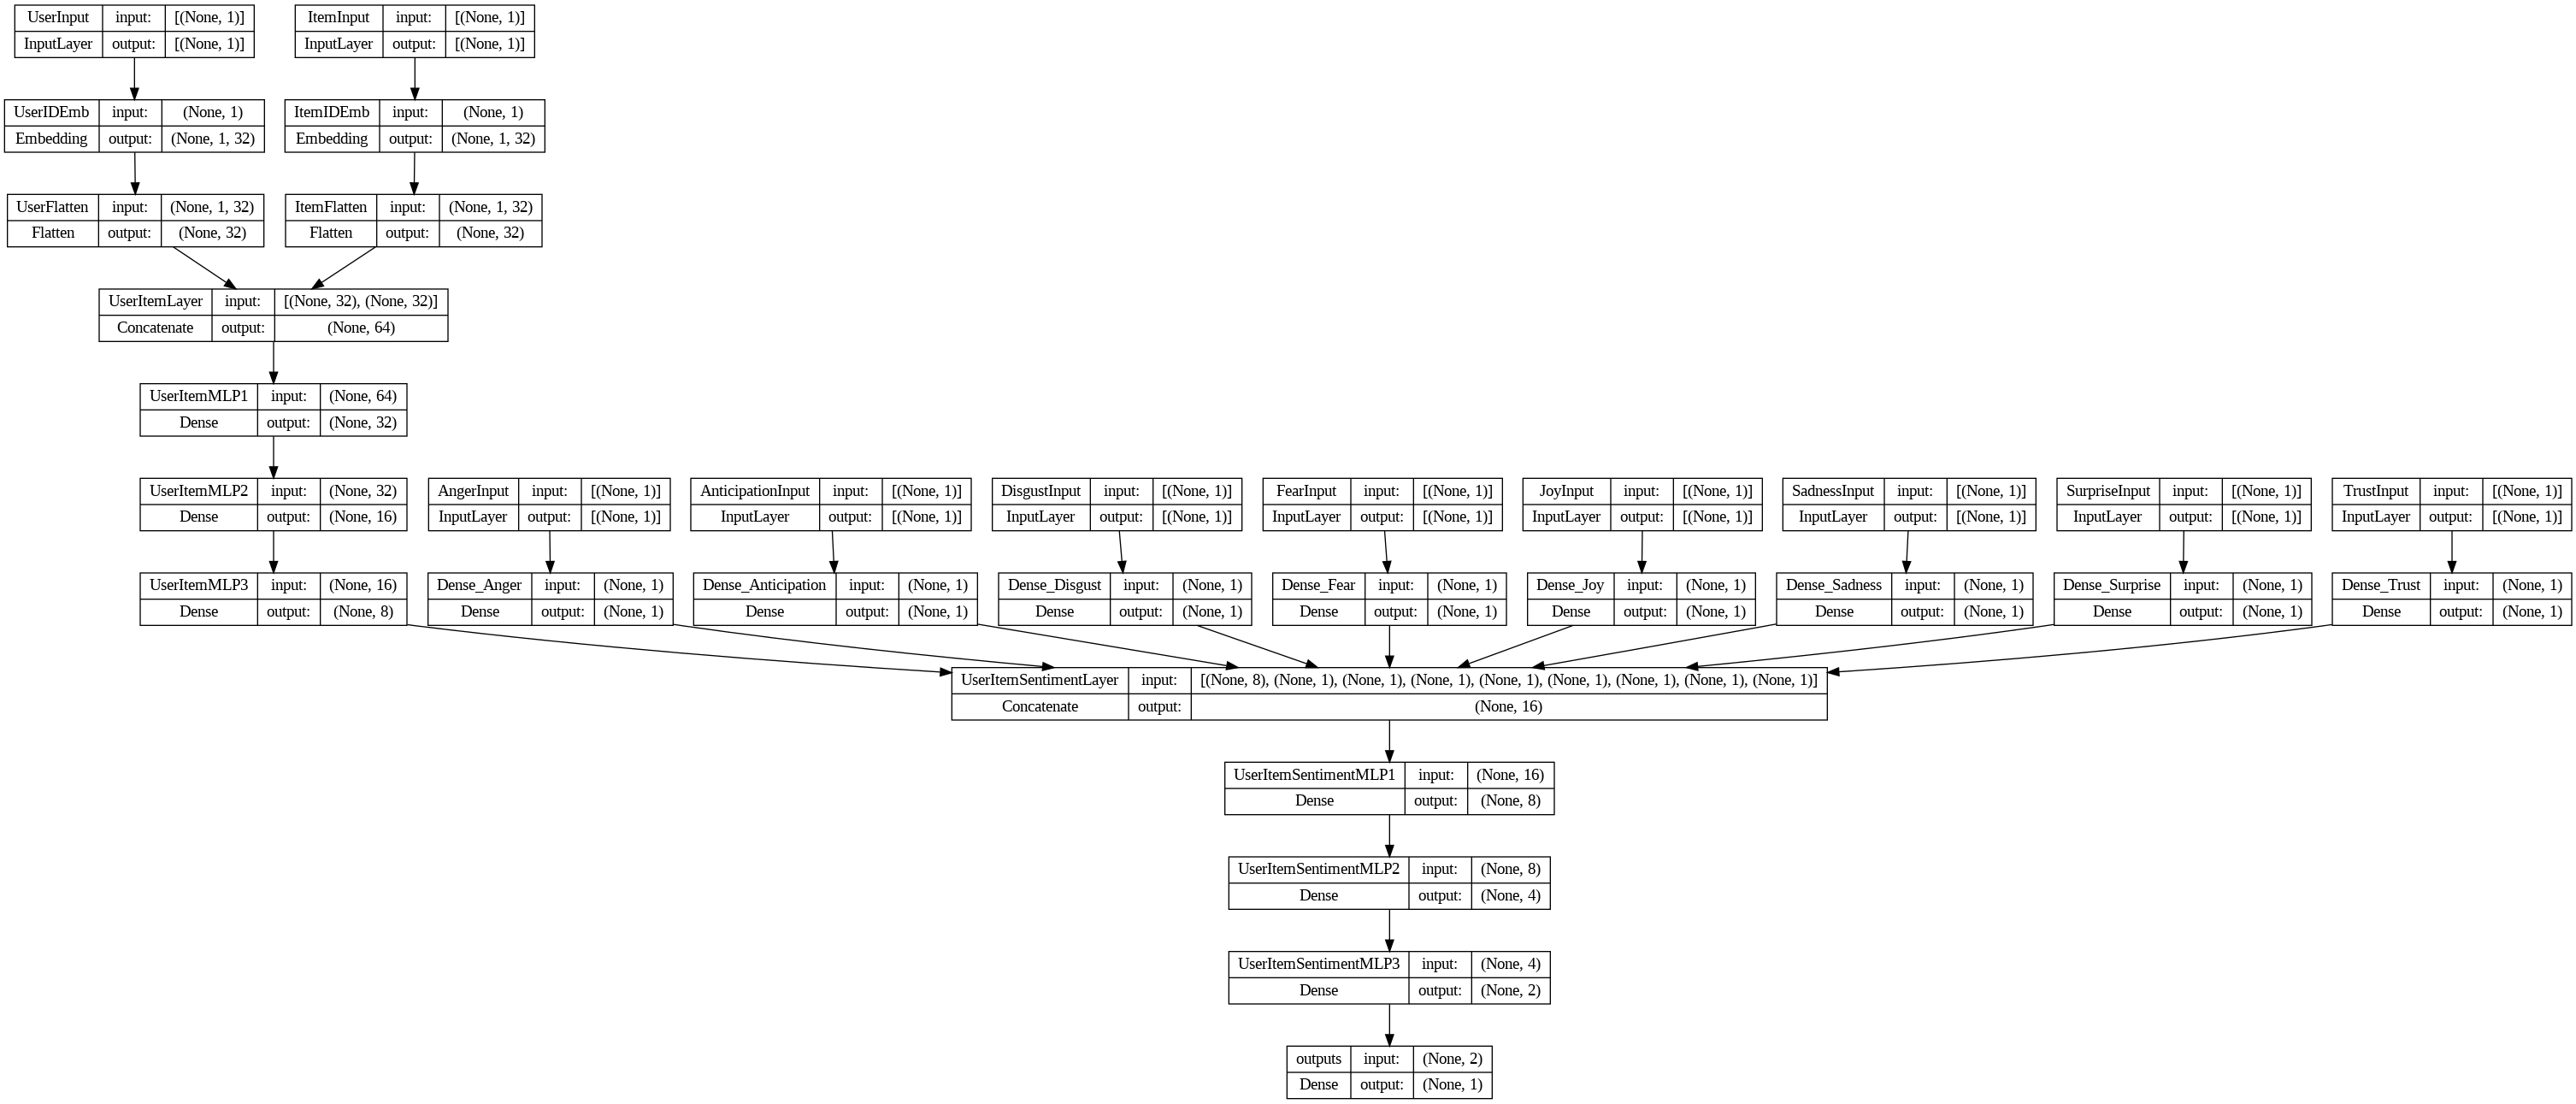

In [ ]:
model = ModelBuild(user_num = 281335, item_num = 59044, id_dims = 32, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)
plot_model(model, show_shapes=True, show_layer_names=True)

# Jihyeon_ex
- 모든 파라미터 돌려

- user_num = 281335
- item_num = 59044
--------
- id_dims = [256,128,64,32]
- total_layer_dims =  [128, 64, 32, 16] # ex. 128 -> 128 , 64, 32...
- total_n_layer = [3] # concat(64) -> 64-32-16
- lr = [0.0001, 0.0005, 0.001, 0.005]

In [11]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)


    history = model.fit([train_set['userID'], train_set['movieID'], train_set['anger'], train_set['anticipation'], train_set['disgust'], train_set['fear'], train_set['joy'], train_set['sadness'], train_set['surprise'], train_set['trust']],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'], valid_set['anger'], valid_set['anticipation'], valid_set['disgust'], valid_set['fear'], valid_set['joy'], valid_set['sadness'], valid_set['surprise'], valid_set['trust']],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['anger'], test_set['anticipation'], test_set['disgust'], test_set['fear'], test_set['joy'], test_set['sadness'], test_set['surprise'], test_set['trust']])

    # normalize 안해도 되겠단 생각이.. > 하는게 맞음
    prediction = 4 * norm(prediction) + 1

    # prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    layer_n = total_n_layer
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, layer_n, lr

### 실험1


In [ ]:
'''
- 5core userID num :  281887
- 5core movieID num :  59252
- 5core rating num :  3236784
'''

# 다시 시도...
user_num = 281887
item_num = 59252

id_dims = [256,128,64,32]
total_layer_dims =  [ 128,64,32,16] # ex. 128 -> 128 , 64, 32...
total_n_layer = [3] # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_n_layer, param_lr = [], [], [], [], [],[]
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      for j in total_n_layer:
        MAE_temp, RMSE_temp, embedding_size, layer_dim, layer_n, learning_rate = model_run_param(a, b,j,i)

        MAE.append(MAE_temp)
        RMSE.append(RMSE_temp)
        param_embedding.append(embedding_size)
        param_layer_dim.append(layer_dim)
        param_lr.append(learning_rate)
        param_n_layer.append(layer_n)

Epoch 1/100
2213/2213 [==============================] - 45s 18ms/step - loss: 0.4303 - val_loss: 0.4033
Epoch 2/100
2213/2213 [==============================] - 24s 11ms/step - loss: 0.3749 - val_loss: 0.4010
Epoch 3/100
2213/2213 [==============================] - 22s 10ms/step - loss: 0.3443 - val_loss: 0.4134
Epoch 4/100
2213/2213 [==============================] - 22s 10ms/step - loss: 0.3153 - val_loss: 0.4393
Epoch 5/100
2213/2213 [==============================] - 22s 10ms/step - loss: 0.2881 - val_loss: 0.4609
Epoch 5: early stopping
20230/20230 [==============================] - 47s 2ms/step
embedding:256, layer_dim:128,lr:0.001
MAE: 0.640
RMSE: 0.939
Epoch 1/100
2213/2213 [==============================] - 40s 15ms/step - loss: 0.4233 - val_loss: 0.4031
Epoch 2/100
2213/2213 [==============================] - 24s 11ms/step - loss: 0.3723 - val_loss: 0.4027
Epoch 3/100
2213/2213 [==============================] - 22s 10ms/step - loss: 0.3402 - val_loss: 0.4236
Epoch 4/100
221

In [ ]:
jihyeon_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
jihyeon_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,256,128,0.001,0.640154,0.938882
1,256,128,0.005,0.655212,0.945144
2,256,64,0.001,0.661134,0.945497
3,256,64,0.005,0.649485,0.942788
4,256,32,0.001,0.644924,0.943847
5,256,32,0.005,0.661067,0.951249
6,256,16,0.001,0.612217,0.971552
7,256,16,0.005,0.623949,0.954029
8,128,128,0.001,0.641209,0.939072
9,128,128,0.005,0.652024,0.943092


In [ ]:
# 결과 저장
jihyeon_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.polar5core_final_proposed_result_.csv",index=False)


# n-core 실험
### sparsity 정리

- -----
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- sparsity : 0.00018464025725
- -----
- 5core userID num :  281335
- 5core movieID num :  59044
- 5core rating num :   3215686
- sparsity : 0.000193586067903
- -----
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
- sparsity : 0.0007484205326408776
- -----
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
- sparsity : 0.0018993736461126469
- -----
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
- sparsity : 0.004380935806310133

### 10-core 실험
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
- sparsity : 0.0007484205326408776

In [ ]:
# 10-core data load
# data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
653675,6127,10734,1.00,0.9937,0.433,0.514,0.053,1.14,11.36,2.27,7.95,14.77,2.27,4.55,17.05,3.41,19.32
1273428,21123,22756,0.75,0.8126,0.319,0.452,0.229,5.08,0.00,3.39,5.08,3.39,6.78,1.69,1.69,11.86,6.78
128409,77170,1563,0.00,-0.5106,0.193,0.501,0.306,12.00,4.00,8.00,8.00,8.00,8.00,4.00,8.00,12.00,8.00
511768,65119,7736,1.00,0.7579,0.484,0.516,0.000,0.00,9.09,0.00,0.00,0.00,0.00,0.00,9.09,0.00,9.09
1188111,14873,21264,1.00,0.8779,0.558,0.442,0.000,0.00,0.00,0.00,0.00,9.09,0.00,0.00,0.00,0.00,9.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745218,28884,13048,0.75,-0.2023,0.000,0.933,0.067,0.00,4.88,0.00,0.00,7.32,4.88,2.44,9.76,4.88,17.07
1147948,48579,20789,1.00,0.5859,0.792,0.208,0.000,0.00,50.00,0.00,0.00,50.00,0.00,0.00,50.00,0.00,50.00
546332,28099,8559,0.75,0.9612,0.438,0.562,0.000,3.23,12.90,0.00,6.45,9.68,0.00,3.23,9.68,6.45,12.90
47651,475,371,0.25,0.9937,0.472,0.498,0.030,1.20,9.64,2.41,1.20,10.84,1.20,1.20,13.25,3.61,21.69


In [ ]:
'''
- 10core userID num :  79542
- 10core movieID num :  30084
- 10core rating num :  1785734
'''

# 다시 시도...
user_num = 79542
item_num = 30084

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = [3] # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_n_layer, param_lr = [], [], [], [], [],[]
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      for j in total_n_layer:
        MAE_temp, RMSE_temp, embedding_size, layer_dim, layer_n, learning_rate = model_run_param(a, b,j,i)

        MAE.append(MAE_temp)
        RMSE.append(RMSE_temp)
        param_embedding.append(embedding_size)
        param_layer_dim.append(layer_dim)
        param_lr.append(learning_rate)
        param_n_layer.append(layer_n)

Epoch 1/100
1221/1221 [==============================] - 28s 18ms/step - loss: 0.4426 - val_loss: 0.4096
Epoch 2/100
1221/1221 [==============================] - 10s 8ms/step - loss: 0.3924 - val_loss: 0.4060
Epoch 3/100
1221/1221 [==============================] - 10s 8ms/step - loss: 0.3754 - val_loss: 0.4111
Epoch 4/100
1221/1221 [==============================] - 10s 8ms/step - loss: 0.3565 - val_loss: 0.4234
Epoch 5/100
1221/1221 [==============================] - 9s 8ms/step - loss: 0.3336 - val_loss: 0.4411
Epoch 5: early stopping
11161/11161 [==============================] - 26s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.635
RMSE: 0.916
Epoch 1/100
1221/1221 [==============================] - 28s 18ms/step - loss: 0.4308 - val_loss: 0.4099
Epoch 2/100
1221/1221 [==============================] - 10s 8ms/step - loss: 0.3911 - val_loss: 0.4061
Epoch 3/100
1221/1221 [==============================] - 10s 8ms/step - loss: 0.3707 - val_loss: 0.4172
Epoch 4/100
1221/1221 

In [ ]:
core10_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core10_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.635061,0.916464
1,128,128,0.005,0.639653,0.918254
2,128,64,0.001,0.638879,0.917154
3,128,64,0.005,0.633712,0.921144
4,128,32,0.001,0.650780,0.924596
5,128,32,0.005,0.751715,1.041341
6,64,128,0.001,0.634968,0.917528
7,64,128,0.005,0.641182,0.918075
8,64,64,0.001,0.640208,0.918937
9,64,64,0.005,0.632551,0.919205


In [ ]:
core10_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.polar10core_final_proposed_result_.csv",index=False)



### 15-core 실험
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
- sparsity : 0.0018993736461126469

In [ ]:
# 15-core data load
# 15-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
931639,32594,15035,0.75,0.5994,0.197,0.667,0.136,5.77,5.77,2.88,5.77,5.77,2.88,3.85,10.58,9.62,13.46
448266,9454,7081,1.00,-0.9917,0.206,0.479,0.315,11.85,6.64,12.80,13.27,4.27,9.95,7.58,5.69,17.06,7.58
746392,26005,12529,1.00,0.7717,0.398,0.460,0.142,5.56,11.11,0.00,0.00,16.67,0.00,5.56,11.11,0.00,27.78
901694,11666,14638,1.00,0.8442,0.502,0.356,0.142,0.00,8.33,0.00,0.00,25.00,0.00,8.33,8.33,0.00,25.00
1075049,30611,16892,0.75,0.6597,0.730,0.270,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.00,25.00,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492494,15287,8121,1.00,0.9590,0.470,0.411,0.119,0.00,3.57,0.00,0.00,25.00,10.71,7.14,7.14,7.14,25.00
725400,9505,12174,0.75,0.4404,0.744,0.256,0.000,0.00,50.00,0.00,0.00,50.00,0.00,50.00,100.00,0.00,50.00
96848,26300,1326,0.75,0.9274,0.335,0.665,0.000,2.94,8.82,2.94,2.94,8.82,2.94,2.94,26.47,2.94,26.47
1011186,6816,16123,1.00,0.3612,1.000,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
'''
- 15core userID num :  33821
- 15core movieID num :  17410
- 15core rating num :  1115902
'''

# 다시 시도...
user_num = 33821
item_num = 17410

id_dims = [128,64, 32]
total_layer_dims =  [128,64, 32] # ex. 128 -> 128 , 64, 32...
total_n_layer = [3] # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_n_layer, param_lr = [], [], [], [], [],[]
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      for j in total_n_layer:
        MAE_temp, RMSE_temp, embedding_size, layer_dim, layer_n, learning_rate = model_run_param(a, b,j,i)

        MAE.append(MAE_temp)
        RMSE.append(RMSE_temp)
        param_embedding.append(embedding_size)
        param_layer_dim.append(layer_dim)
        param_lr.append(learning_rate)
        param_n_layer.append(layer_n)

Epoch 1/100
763/763 [==============================] - 30s 32ms/step - loss: 0.4564 - val_loss: 0.4167
Epoch 2/100
763/763 [==============================] - 8s 11ms/step - loss: 0.4021 - val_loss: 0.4123
Epoch 3/100
763/763 [==============================] - 6s 8ms/step - loss: 0.3910 - val_loss: 0.4140
Epoch 4/100
763/763 [==============================] - 6s 8ms/step - loss: 0.3786 - val_loss: 0.4169
Epoch 5/100
763/763 [==============================] - 6s 8ms/step - loss: 0.3615 - val_loss: 0.4308
Epoch 5: early stopping
6975/6975 [==============================] - 17s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.635
RMSE: 0.907
Epoch 1/100
763/763 [==============================] - 25s 25ms/step - loss: 0.4376 - val_loss: 0.4166
Epoch 2/100
763/763 [==============================] - 8s 10ms/step - loss: 0.4013 - val_loss: 0.4125
Epoch 3/100
763/763 [==============================] - 6s 8ms/step - loss: 0.3868 - val_loss: 0.4143
Epoch 4/100
763/763 [======================

In [ ]:
core15_df= pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core15_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.635046,0.907296
1,128,128,0.005,0.647355,0.909749
2,128,64,0.001,0.637622,0.908423
3,128,64,0.005,0.651194,0.912900
4,128,32,0.001,0.636849,0.910038
5,128,32,0.005,0.770849,1.057138
6,64,128,0.001,0.635137,0.906663
7,64,128,0.005,0.651713,0.909595
8,64,64,0.001,0.638216,0.908402
9,64,64,0.005,0.654165,0.913989


In [ ]:
core15_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.polar15core_final_proposed_result_.csv",index=False)


### 20-core 실험
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
- sparsity : 0.004380935806310133

In [12]:
# 20-core data load
# 20-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [13]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
391547,12873,6146,0.75,0.9337,0.244,0.587,0.169,8.70,2.61,10.43,11.30,6.09,6.09,1.74,5.22,17.39,10.43
188597,4104,2889,1.00,0.9501,0.324,0.676,0.000,0.00,18.92,0.00,2.70,18.92,2.70,5.41,16.22,0.00,27.03
69539,13121,984,0.50,0.9181,0.334,0.491,0.175,5.56,7.41,3.70,3.70,9.26,3.70,7.41,9.26,7.41,11.11
408837,12586,6406,0.25,-0.4019,0.000,0.816,0.184,15.38,7.69,7.69,0.00,0.00,7.69,0.00,0.00,23.08,0.00
518360,3801,7835,0.50,-0.9655,0.235,0.491,0.274,9.29,10.18,8.41,12.39,8.85,9.29,3.98,12.39,15.04,18.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618989,11796,9042,0.50,0.0000,0.000,1.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
523113,4904,7902,0.75,0.5267,0.379,0.474,0.147,0.00,15.38,7.69,0.00,7.69,0.00,0.00,7.69,7.69,15.38
8758,10511,125,0.75,0.6369,0.677,0.323,0.000,0.00,0.00,0.00,0.00,33.33,0.00,0.00,0.00,0.00,33.33
301539,5489,4525,0.25,-0.9212,0.146,0.663,0.191,3.72,4.19,3.72,9.30,3.26,6.51,4.19,3.26,9.30,6.05


In [9]:
'''
- 20core userID num :  16221
- 20core movieID num :  9919
- 20core rating num :  701036
'''

# 다시 시도...
user_num = 16221
item_num = 9919

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = [3] # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [21]:
# 추가실험
user_num = 16221
item_num = 9919

id_dims = [32]
total_layer_dims =  [64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = [3] # concat(64) -> 64-32-16
lr = [0.001, 0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_n_layer, param_lr = [], [], [], [], [],[]
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      for j in total_n_layer:
        MAE_temp, RMSE_temp, embedding_size, layer_dim, layer_n, learning_rate = model_run_param(a, b,j,i)

        MAE.append(MAE_temp)
        RMSE.append(RMSE_temp)
        param_embedding.append(embedding_size)
        param_layer_dim.append(layer_dim)
        param_lr.append(learning_rate)
        param_n_layer.append(layer_n)

Epoch 1/100
480/480 [==============================] - 23s 37ms/step - loss: 0.4598 - val_loss: 0.4274
Epoch 2/100
480/480 [==============================] - 5s 10ms/step - loss: 0.4174 - val_loss: 0.4220
Epoch 3/100
480/480 [==============================] - 4s 9ms/step - loss: 0.4089 - val_loss: 0.4213
Epoch 4/100
480/480 [==============================] - 4s 9ms/step - loss: 0.4021 - val_loss: 0.4220
Epoch 5/100
480/480 [==============================] - 4s 9ms/step - loss: 0.3953 - val_loss: 0.4251
Epoch 6/100
480/480 [==============================] - 4s 9ms/step - loss: 0.3864 - val_loss: 0.4294
Epoch 6: early stopping
4382/4382 [==============================] - 10s 2ms/step
embedding:32, layer_dim:64,lr:0.001
MAE: 0.635
RMSE: 0.901
Epoch 1/100
480/480 [==============================] - 23s 36ms/step - loss: 0.4457 - val_loss: 0.4252
Epoch 2/100
480/480 [==============================] - 5s 10ms/step - loss: 0.4151 - val_loss: 0.4210
Epoch 3/100
480/480 [========================

In [ ]:
core20_df2 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core20_df2

In [ ]:
core20_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core20_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.630915,0.901554
1,128,128,0.005,0.630647,0.903448
2,128,64,0.001,0.639348,0.901322
3,128,64,0.005,0.656058,0.904176
4,128,32,0.001,0.637878,0.903339
5,128,32,0.005,0.847357,1.131346
6,64,128,0.001,0.633804,0.902159
7,64,128,0.005,0.632172,0.902446
8,64,64,0.001,0.637752,0.900624
9,64,64,0.005,0.649815,0.903093


In [ ]:
core20_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.polar20core_final_proposed_result_.csv",index=False)



### 2-core 실험
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- sparsity : 0.00018464025725

In [ ]:
# 2-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1601217,258079,33219,0.25,0.9409,0.246,0.607,0.148,3.14,2.52,2.52,3.14,3.14,2.52,1.26,3.77,8.81,13.21
2109928,267784,20408,0.50,-0.0314,0.319,0.414,0.267,16.67,8.33,0.00,16.67,8.33,8.33,8.33,8.33,25.00,8.33
1044096,213376,18340,1.00,0.6249,0.804,0.196,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
173120,61529,1914,1.00,0.3612,0.455,0.545,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2097197,228461,42684,0.50,0.7003,0.425,0.421,0.154,7.69,15.38,7.69,15.38,7.69,23.08,0.00,7.69,23.08,7.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15501,8927,132,1.00,0.4404,0.744,0.256,0.000,0.00,50.00,0.00,0.00,50.00,0.00,50.00,50.00,0.00,50.00
1977038,178288,40882,1.00,-0.8187,0.137,0.593,0.271,3.85,5.77,7.69,7.69,3.85,3.85,7.69,3.85,5.77,9.62
1438382,75224,29409,1.00,0.8555,0.356,0.644,0.000,0.00,10.00,0.00,5.00,10.00,0.00,5.00,15.00,0.00,20.00
2593677,238021,51001,1.00,0.4201,0.358,0.642,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
'''
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
'''
# 다시 시도...
user_num = 297514
item_num = 60085

id_dims = [128, 64, 32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = [3] # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_n_layer, param_lr = [], [], [], [], [],[]
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      for j in total_n_layer:
        MAE_temp, RMSE_temp, embedding_size, layer_dim, layer_n, learning_rate = model_run_param(a, b,j,i)

        MAE.append(MAE_temp)
        RMSE.append(RMSE_temp)
        param_embedding.append(embedding_size)
        param_layer_dim.append(layer_dim)
        param_lr.append(learning_rate)
        param_n_layer.append(layer_n)

Epoch 1/100
2257/2257 [==============================] - 43s 16ms/step - loss: 0.4297 - val_loss: 0.4035
Epoch 2/100
2257/2257 [==============================] - 21s 9ms/step - loss: 0.3755 - val_loss: 0.4028
Epoch 3/100
2257/2257 [==============================] - 21s 9ms/step - loss: 0.3465 - val_loss: 0.4113
Epoch 4/100
2257/2257 [==============================] - 20s 9ms/step - loss: 0.3189 - val_loss: 0.4363
Epoch 5/100
2257/2257 [==============================] - 20s 9ms/step - loss: 0.2912 - val_loss: 0.4735
Epoch 5: early stopping
20630/20630 [==============================] - 48s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.638
RMSE: 0.944
Epoch 1/100
2257/2257 [==============================] - 38s 14ms/step - loss: 0.4222 - val_loss: 0.4022
Epoch 2/100
2257/2257 [==============================] - 20s 9ms/step - loss: 0.3702 - val_loss: 0.4026
Epoch 3/100
2257/2257 [==============================] - 20s 9ms/step - loss: 0.3380 - val_loss: 0.4195
Epoch 4/100
2257/2257

In [ ]:
core2_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core2_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.638095,0.943516
1,128,128,0.005,0.676603,0.948945
2,128,64,0.001,0.673198,0.949328
3,128,64,0.005,0.678657,0.948106
4,128,32,0.001,0.643900,0.947258
5,128,32,0.005,0.640704,0.945698
6,64,128,0.001,0.638587,0.943744
7,64,128,0.005,0.674385,0.948624
8,64,64,0.001,0.642973,0.943002
9,64,64,0.005,0.681011,0.947813


In [ ]:
core2_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.polar2core_final_proposed_result_.csv",index=False)

